# 자전거 대여수 예측
- ### colab에서 실행 (추천)

## 데이터 : Kaggle 사이트에 소개된 예제
- ### https://goo.gl/s8qSL5

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer
%matplotlib inline

## colab에서 실행하는 경우 필요한 코드

In [2]:
!curl -L https://goo.gl/s8qSL5  -o ./bike_train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100  643k  100  643k    0     0   188k      0  0:00:03  0:00:03 --:--:--  356k


### read_csv() 인수
- index_col : row index 열 정의
- parse_dates : 인덱스 열이나 복수 열의 날짜를 파싱할지 여부
- sep : 필드 분리자 정의
- dayfirst : 유럽식 날짜 표기 (날짜 표기에서 12 이하의 숫자가 두 개 연속인 경우, 날짜와 월 중에서 날짜를 먼저 표시했다는 의미)
- header : 헤더 줄의 수. 헤더가 존재하지 않으면 None
- skiprows : 읽지 않고 그냥 넘어갈 줄의 수
- names : 열 이름

In [5]:
train = pd.read_csv("bike_train.csv", parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


## datetime 데이터 분해

In [12]:
train["d-year"] = train["datetime"].dt.year
train["d-month"] = train["datetime"].dt.month
train["d-day"] = train["datetime"].dt.day
train["d-hour"] = train["datetime"].dt.hour
train["d-minute"] = train["datetime"].dt.minute
train["d-second"] = train["datetime"].dt.second

train[["datetime", "d-year", "d-month", "d-day", "d-hour", "d-minute", "d-second"]].head()

,datetime,d-year,d-month,d-day,d-hour,d-minute,d-second
0,2011-01-01 00:00:00,2011,1,1,0,0,0
1,2011-01-01 01:00:00,2011,1,1,1,0,0
2,2011-01-01 02:00:00,2011,1,1,2,0,0
3,2011-01-01 03:00:00,2011,1,1,3,0,0
4,2011-01-01 04:00:00,2011,1,1,4,0,0


### Seaborn
- Matplotlib을 기반으로 다양한 색상 테마와 통계용 차트 등의 기능을 추가한 시각화 패키지
- 기본적인 시각화 기능은 Matplotlib 패키지에 의존
- 통계 기능은 Statsmodels 패키지에 의존
- Seaborn에 대한 자세한 내용은 다음 웹사이트를 참조
    - https://seaborn.github.io/

### 여러 개의 subplots 그리기
- figure, axes = plt.subplots(2, 2) : (rows(상하), cols(좌우))
- figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

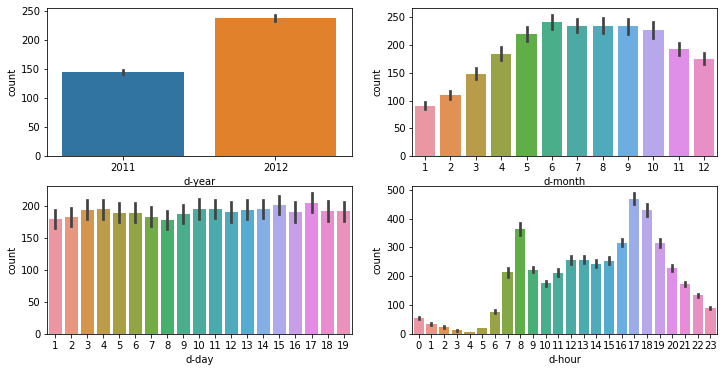

In [13]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(12, 6)

sns.barplot(data=train, x="d-year", y="count", ax=ax1)
sns.barplot(data=train, x="d-month", y="count", ax=ax2)
sns.barplot(data=train, x="d-day", y="count", ax=ax3)
sns.barplot(data=train, x="d-hour", y="count", ax=ax4)

## 시간대별 평균 대여수 (주중, 주말 구분)

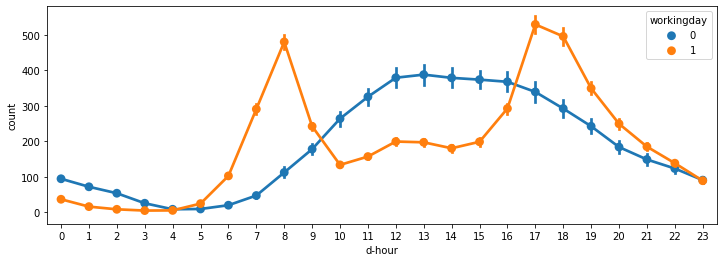

In [14]:
plt.figure(figsize=(12,4))
sns.pointplot(data=train, x="d-hour", y="count", hue="workingday")

## 시간대별 대여수 - 요일 구분

In [15]:
train["d-dayofweek"] = train["datetime"].dt.dayofweek

print(train.shape)
train[["datetime", "d-dayofweek"]].head()

(10886, 19)


,datetime,d-dayofweek
0,2011-01-01 00:00:00,5
1,2011-01-01 01:00:00,5
2,2011-01-01 02:00:00,5
3,2011-01-01 03:00:00,5
4,2011-01-01 04:00:00,5


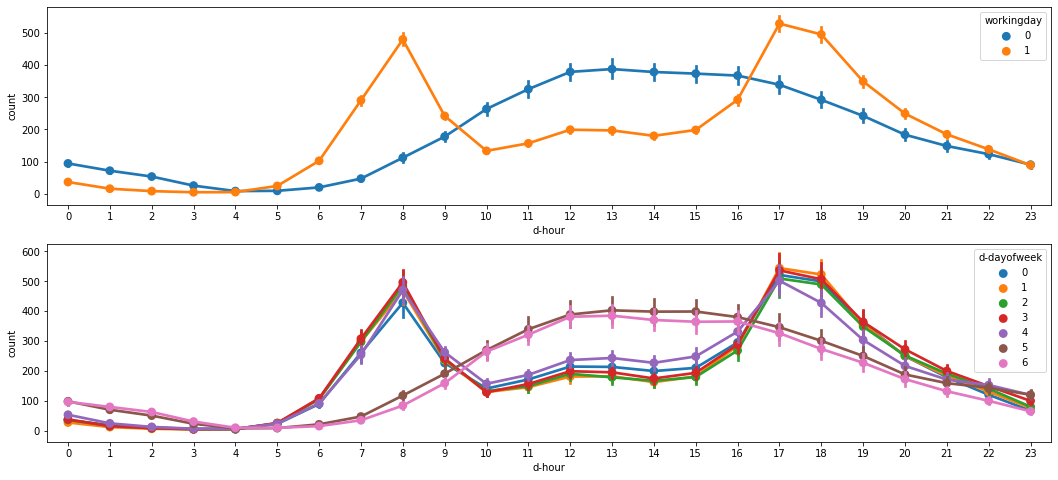

In [16]:
figure, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(18, 8)

sns.pointplot(data=train, x="d-hour", y="count", hue="workingday", ax=ax1)
sns.pointplot(data=train, x="d-hour", y="count", hue="d-dayofweek", ax=ax2)

## 연도와 월을 합한 특성 변수 생성

- apply(f) : 인수로 제시된 f 함수를 해당 데이터 전체에 일괄 적용

In [10]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train["d-year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", "d-year_month"]].head()

(10886, 20)


,datetime,d-year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


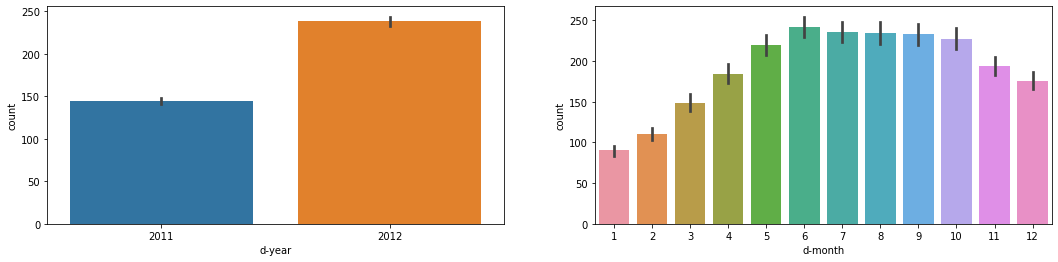

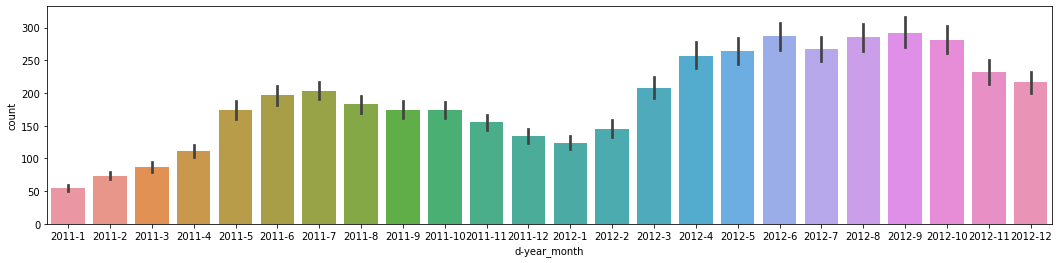

In [11]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 4)

sns.barplot(data=train, x="d-year", y="count", ax=ax1)
sns.barplot(data=train, x="d-month", y="count", ax=ax2)

figure, ax3 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18, 4)

sns.barplot(data=train, x="d-year_month", y="count", ax=ax3)

## 훈련 데이터 구성
   - X = train[features]
   - y = train["count"]

- ### 훈련에 사용할 특성 선택
    - features

In [27]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'd-year', 'd-month', 'd-day', 'd-hour', 'd-minute', 'd-second',
       'd-dayofweek'],
      dtype='object')

In [28]:
features = ["season", "holiday", "workingday", "weather",
                 "temp", "atemp", "humidity", "windspeed",
                 "d-year", "d-hour", "d-dayofweek"]

In [29]:
X = train[features]

print(X.shape)
X.head()

(10886, 11)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,d-year,d-hour,d-dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,0.0,2011,1,5
2,1,0,0,1,9.02,13.635,80,0.0,2011,2,5
3,1,0,0,1,9.84,14.395,75,0.0,2011,3,5
4,1,0,0,1,9.84,14.395,75,0.0,2011,4,5


In [30]:
y = train["count"]
print(y.shape)

(10886,)


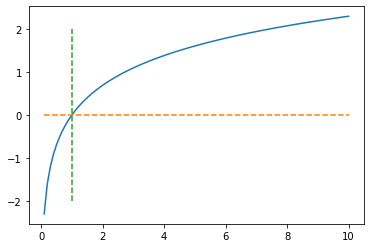

In [31]:
import numpy as np
import matplotlib.pyplot as plt

xx= np.linspace(0.1, 10, 100)
yy = np.log(xx)
plt.plot(xx, yy)

x1 = np.linspace(0.1, 10, 100)
y1 = np.linspace(0, 0, 100)
plt.plot(x1, y1, '--')

x2 = np.linspace(1, 1, 100)
y2 = np.linspace(-2, 2, 100)
plt.plot(x2, y2, '--')

In [32]:
import numpy as np
y_log = np.log(y + 1)

print(y_log.shape)
y_log.head()

(10886,)


0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: count, dtype: float64

## 간단한 예측 모델
- #### 랜덤 포레스트(30)
- #### 선형 회귀

In [33]:
np.random.seed(11)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size = 0.2)

### 랜덤 포레스트

In [34]:
model = RandomForestRegressor(n_estimators= 30)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9580883210969734

In [35]:
list(zip(y_test, model.predict(X_test)))[:10]

[(1.9459101490553132, 2.0403146519508772),
 (3.7612001156935624, 3.7669927593559467),
 (6.415096959171596, 6.302535786676932),
 (2.833213344056216, 2.824032746730312),
 (4.2626798770413155, 4.443539522423507),
 (2.70805020110221, 3.2117684044501233),
 (6.030685260261263, 5.914215047904423),
 (5.4510384535657, 5.41472429655433),
 (5.472270673671475, 5.697741213725065),
 (5.673323267171493, 5.595541299114385)]

In [36]:
X_train[:5]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,d-year,d-hour,d-dayofweek
7560,2,0,1,3,22.14,25.760,88,19.0012,2012,9,0
8090,2,0,0,1,25.42,31.060,57,7.0015,2012,11,6
30,1,0,0,2,16.40,20.455,76,12.9980,2011,7,6
7290,2,0,1,2,18.86,22.725,88,0.0000,2012,3,3
8665,3,0,1,2,32.80,37.120,52,12.9980,2012,10,4


### 선형회귀

In [37]:
model = LinearRegression()
model.fit(X_train, y_train)

model.score(X_test, y_test)

0.47259501985061175

### 결정 트리

In [38]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

model.score(X_test, y_test)

0.915749021768606

## 성능 지표( score) 함수 변경

### RMSLE
- 과대평가 된 항목보다는 과소평가 된 항목에 페널티를 준다.(log 함수 참조)
- 오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root)으로 값이 작을수록 정밀도가 높다.
- 0에 가까운 값이 나올수록 정밀도가 높은 값이다.
- 작은 에러일수록 더 크게 부각하여 학습을 더 정밀하게 하도록 유도
- https://programmers.co.kr/learn/courses/21/lessons/943

### make_scorer()
- Make a scorer from a performance metric or loss function.

In [39]:
def rmsle(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
    
    log_predict = np.log(predict + 1)
    log_actual = np.log(actual + 1)
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()    
    score = np.sqrt(mean_difference)
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

## Score (lmsle)

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$

# 모델의 최적화
### 최적의 하이퍼파라미터를 찾는 과정
- #### 그리드 탐색
- #### 랜덤 탐색

### 그리드(Grid) 탐색
- 여러 가지 하이퍼 파라미터들의 조합에 대해서 가능한 경우를 모두 수행해보는 방식
- 그 중 가장 성능이 좋은 경우를 찾는다

- RandomForestRegressor의 경우 CPU가 많을수록 비례하여 빨리 수행 
- n_jobs = 2 : CPU core를 2개 사용하여 수행
- n_jobs = -1 : 사용하는 컴퓨터의 모든 CPU core를 사용하여 수행

- cross_val_score : default scoring = 'accuracy'
- cv : 교차검증 생성 객체 수 

In [40]:
n_estimators = 30

max_depth_list = [10, 20, 30]
max_features_list = [0.3, 0.5, 0.9]

hyperparameters_list = []

for max_depth in max_depth_list:
    for max_features in max_features_list:
        model = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      max_features=max_features,
                                      random_state=11,
                                      n_jobs=-1)

        score = cross_val_score(model, X_train, y_train, cv=5,
                                scoring=rmsle_scorer).mean()

        hyperparameters_list.append({
            'score': score,
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'max_features': max_features,
        })

        print("Score = {0:.5f}".format(score))

hyperparameters_list

Score = 0.12306
Score = 0.09950
Score = 0.08983
Score = 0.10606
Score = 0.09078
Score = 0.08667
Score = 0.10716
Score = 0.09140
Score = 0.08699


[{'score': 0.12306276038916239,
  'n_estimators': 30,
  'max_depth': 10,
  'max_features': 0.3},
 {'score': 0.09949546271969718,
  'n_estimators': 30,
  'max_depth': 10,
  'max_features': 0.5},
 {'score': 0.08982572027937767,
  'n_estimators': 30,
  'max_depth': 10,
  'max_features': 0.9},
 {'score': 0.10606278664903027,
  'n_estimators': 30,
  'max_depth': 20,
  'max_features': 0.3},
 {'score': 0.09078184215554591,
  'n_estimators': 30,
  'max_depth': 20,
  'max_features': 0.5},
 {'score': 0.08666639731103369,
  'n_estimators': 30,
  'max_depth': 20,
  'max_features': 0.9},
 {'score': 0.10716177056607852,
  'n_estimators': 30,
  'max_depth': 30,
  'max_features': 0.3},
 {'score': 0.09140018501612993,
  'n_estimators': 30,
  'max_depth': 30,
  'max_features': 0.5},
 {'score': 0.08698818547171935,
  'n_estimators': 30,
  'max_depth': 30,
  'max_features': 0.9}]

#### 성능이 좋은 순으로 나열
- pd.DataFrame.from_dict() : dictionary -> DataFrame

In [26]:
hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

(9, 4)


,score,n_estimators,max_depth,max_features
5,0.086666,30,20,0.9
8,0.086988,30,30,0.9
2,0.089826,30,10,0.9
4,0.090782,30,20,0.5
7,0.091400,30,30,0.5


### 랜덤(Random) 탐색
- 그리드 탐색 : 여러 경우의 수를 모두 탐색하는데 시간도 오래 걸리고 최적의 값을 놓치는 경우가 있다.
- 그리드 탐색의 단점 보완 : 최적의 값을 놓치는 문제점을 개선하고 탐색 시간도 줄이는 방법

### 랜덤 탐색
- 1단계 : 일정한 범위 내에서 랜덤하게 성능을 실험하여 대체로 어떤 영역에서 성능이 좋은지를 찾는다.
- 2단계 : 성능이 좋은 영역을 중심으로 세밀하게 탐색

In [27]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [28]:
hyperparameters_list = []

n_estimators = 30
num_epoch = 10

for epoch in range(num_epoch):
    max_depth = np.random.randint(low=2, high=100)
    max_features = np.random.uniform(low=0.1, high=1.0)

    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  random_state=37,
                                  n_jobs=-1)

    score = cross_val_score(model, X_train, y_train, cv=5,
                            scoring=rmsle_scorer).mean()

    hyperparameters_list.append({
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    })

    print("Score = {0:.5f}".format(score))

hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

Score = 0.08708
Score = 0.12284
Score = 0.12284
Score = 0.14213
Score = 0.09196
Score = 0.18697
Score = 0.08892
Score = 0.08939
Score = 0.08892
Score = 0.08760
(10, 4)


,score,n_estimators,max_depth,max_features
0,0.087076,30,76,0.804363
9,0.087604,30,82,0.708922
6,0.088916,30,79,0.575713
8,0.088916,30,74,0.577014
7,0.089392,30,12,0.700990


### 상세 탐색

In [29]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

hyperparameters_list = []

n_estimators = 10
num_epoch = 10

for epoch in range(num_epoch):
    max_depth = np.random.randint(low=10, high=70)
    max_features = np.random.uniform(low=0.4, high=1.0)

    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_features=max_features,
                                  random_state=37,
                                  n_jobs=-1)

    score = cross_val_score(model, X_train, y_train, cv=5,
                            scoring=rmsle_scorer).mean()

    hyperparameters_list.append({
        'score': score,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'max_features': max_features,
    })

    print("Score = {0:.5f}".format(score))

hyperparameters_list = pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list = hyperparameters_list.sort_values(by="score")

print(hyperparameters_list.shape)
hyperparameters_list.head()

Score = 0.09313
Score = 0.09021
Score = 0.09313
Score = 0.08941
Score = 0.09129
Score = 0.08941
Score = 0.09021
Score = 0.08925
Score = 0.09432
Score = 0.09129
(10, 4)


,score,n_estimators,max_depth,max_features
7,0.089249,10,67,0.916531
3,0.089413,10,65,0.841677
5,0.089413,10,49,0.873149
1,0.090206,10,34,0.807500
6,0.090206,10,48,0.802131


## 최종 모델 선택

In [30]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=300,
                              max_depth=70,
                              max_features=0.85,
                              random_state=37,
                              n_jobs=-1)

score = cross_val_score(model, X_train, y_train, cv=5,
                        scoring=rmsle_scorer).mean()

print("Score = {0:.5f}".format(score))

Score = 0.08514


## 주요 특성 변수

In [31]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
                      max_features=0.85, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                      oob_score=False, random_state=37, verbose=0,
                      warm_start=False)

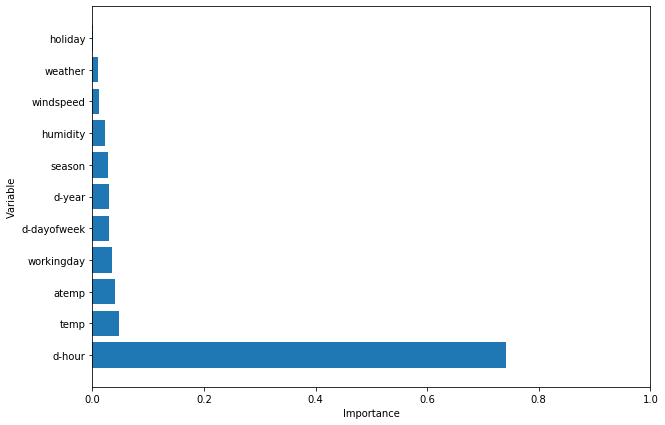

In [32]:
df = pd.DataFrame({'feature':features,'importance':model.feature_importances_ })
df=df.sort_values('importance', ascending=False)
x = df.feature
y = df.importance
ypos = np.arange(len(x))

plt.figure(figsize=(10,7))
plt.barh(x, y)
plt.yticks(ypos, x)
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.xlim(0, 1)
plt.ylim(-1, len(x))
plt.show()

## 그리드 탐색 함수 : GridSearchCV()
- ### 그리드 탐색과 동시에 교차 검증을 수행

In [33]:
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection, svm, metrics
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

import numpy as np

In [34]:
cancer = load_breast_cancer()

In [35]:
np.random.seed(9)
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target)

## Random Forest

In [36]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.958041958041958

###  Grid 탐색
- Grid search 매개변수 설정

In [37]:
params = [{"C": [1,10,100,1000], "kernel":["linear"]},
    {"C": [1,10,100,1000], "kernel":["rbf"], "gamma":[0.001, 0.0001]}]

- params 를 한 눈에 쉽게 보기 위해 임시로 변환 

In [38]:
df_params = pd.DataFrame(params)
df_params

,C,kernel,gamma
0,"[1, 10, 100, 1000]",[linear],NaN
1,"[1, 10, 100, 1000]",[rbf],"[0.001, 0.0001]"


- Grid 탐색 실행

In [39]:
# clf = GridSearchCV(svm.SVC(), params, n_jobs=-1 )  # 이렇게도 OK!!

clf = GridSearchCV(svm.SVC(), param_grid=params, n_jobs=-1 )
clf.fit(X_train, y_train)

print('최적 값 :', clf.best_estimator_)
print('최적 score :', clf.best_score_)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


최적 값 : SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
최적 score : 0.9507042253521126


In [40]:
score = clf.score(X_test, y_test)
print('최종 평가 =',score)

최종 평가 = 0.965034965034965
